<a href="https://colab.research.google.com/github/markelgarcia282/03MIAR----Algoritmos-de-Optimizacion/blob/main/SEMINARIO/Seminario_Markel_Garcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos de optimización - Seminario<br>
Nombre y Apellidos: Markel Garcia Ibarluzea  
Github: https://github.com/markelgarcia282/03MIAR----Algoritmos-de-Optimizacion  
Problema: Organizar los horarios de partidos de La Liga

Descripción del problema:

Desde la La Liga de fútbol profesional se pretende organizar los horarios de los partidos de
liga de cada jornada. Se conocen algunos datos que nos deben llevar a diseñar un
algoritmo que realice la asignación de los partidos a los horarios de forma que maximice la
audiencia.

(*) La respuesta es obligatoria





                                        

In [ ]:
from time import time
import random
from copy import deepcopy
import math
import matplotlib.pyplot as plt

(*)¿Cuantas posibilidades hay sin tener en cuenta las restricciones?<br>



¿Cuantas posibilidades hay teniendo en cuenta todas las restricciones.




Respuesta

Sin tener en cuenta las restricciones, el cálculo de posibilidades es equivalente a un problema de combinatoria de distribuir $n$ objetos distinguibles en $m$ recipientes distinguibles, donde $n$ son los partidos que se juegan durante la jornada (en este caso 10), y $m$ son los distintos horarios donde se pueden jugar los partidos (en este caso también 10). Para cada partido, hay $m$ posibles horarios a los que podría estar asignado, por lo que el número total de combinaciones podemos obtenerla por el principio del producto. La cantidad de posibilidades está dada por:

$$Posibilidades = \underbrace{m \times m \times m \times \dots \times m}_\text{n veces} = m^n = 10^{10}$$

Modelo para el espacio de soluciones<br>
(*) ¿Cual es la estructura de datos que mejor se adapta al problema? Argumentalo.(Es posible que hayas elegido una al principio y veas la necesidad de cambiar, arguentalo)


Respuesta

La solución al problema estará dada por un mapa entre horarios y partidos disputados durante la jornada. Por lo tanto, en este caso utilizaremos un diccionario para guardar esta información. Este diccionario tendrá 10 llaves, que corresponderán a los horarios de la jornada, y como valor asociado cada llave tendrá una lista, que contendrá los partidos que se disputarán en ese horario. En caso de que no se dispute ningún partido en alguno de los posibles horarios, el valor asociado a esa llave será sencillamente una lista vacía.

Utilizar un diccionario nos permite establecer una relación explícita entre horarios y partidos jugados en ese horario. Además, los diccionarios en python tienen una complejidad constante $\mathcal{O}(1)$ para operaciones que necesitaremos implementar, como inserción u obtención de datos.

Por otro lado, para los valores del diccionario utilizaremos listas, ya que necesitamos una estructura de datos mutable, para poder eliminar partidos de un horario e insertarlos en otro en busca de la mejor distribución posible. Otras posibles estructuras, como las tuplas, no tienen esta característica necesaria.

Según el modelo para el espacio de soluciones<br>
(*)¿Cual es la función objetivo?

(*)¿Es un problema de maximización o minimización?

Respuesta

El objetivo es los partidos en entre los posibles horarios, de tal manera que se maximice la audiencia durante la jornada. Para ello, debemos tener en cuenta que la audiencia de un partido dependerá de la categoría de los equipos que la disputan (A, B o C), el horario, y si el partido se solapa con otros partidos que se juegan a la misma hora. La función que queremos optimizar será por tanto:

$$\mathcal{J} = \sum_{h=1}^{10}\sum_{p=1}^{P} audiencia(equipo_p^1, equipo_p^2)*CoefHorario_h*CoefSolape_h,$$

donde $equipo_p^1$ y $equipo_p^2$ son el equipo 1 y 2 que participan en el partido $p$ en el horario $h$, $P$ es el número de partidos disputados a la hora $h$, y $CoefHorario_h$ y $CoefSolape_h$ son los coficientes que reducen la audiencia en base al horario en el que se juega y el número de partido en ese horario. Es decir, sumamos la audiencia de todos los partidos para cada horario, multiplicados por los coeficientes asociados al horario en el que se disputa el partido y el coeficiente de solape de partidos en ese horario. El objetivo es maximizar esta función, que es equivalente a maximizar la audiencia de la jornada. Por lo tanto, es un problema de maximización.

La función objetivo depende de los números de audiencia asociados a diferentes combinaciones de categorías de equipos, y también a los coeficientes asociados a los diferentes horarios y a los solapes entre partidos. Toda esta información la escribiremos en forma de diccionarios para obtener los coeficientes necesarios a la hora de calcular la función objetivo.

In [ ]:
# Audiencia base asociada a combinaciones de equipos de diferentes categorías.
audiencia = {'CC': 0.47,
             'BC': 0.75,
             'BB': 0.9,
             'AC': 1.0,
             'AB': 1.3,
             'AA': 2.0}

# Coeficientes asociados a cada posible horario de la jornada.
coef_horarios = {'V20': 0.4,
                 'S12': 0.55,
                 'S16': 0.7,
                 'S18': 0.8,
                 'S20': 1.0,
                 'D12': 0.45,
                 'D16': 0.75,
                 'D18': 0.85,
                 'D20': 1.0,
                 'L20': 0.4}

# Coeficientes asociados a los diferentes números de solapes entre partidos. El -1 no tiene significados lógico, lo inclyo para
# que no haya errores al intentar obtener el coeficiente en horarios en los que no hay ningún partido.
coef_coincidencias = {-1: 0.0, 0: 1.0, 1: 0.75, 2: 0.55, 3: 0.4, 4: 0.3, 5: 0.25, 6: 0.22, 7: 0.2, 8: 0.2, 9: 0.2}

Con estos coeficientes, ahora podemos escribir la función que calculará el objetivo a maximizar, en este caso la audiencia total en la jornada:

In [ ]:
def funcion_objetivo(jornada):
    
    audiencia_total = 0
    
    # Iteramo sobre todos los horarios y los partidos asociados a ese horario.
    for horario, partidos in jornada.items():
        
        # Calculamos la reducción de audiencia a causa de que haya más de un partido en este horario.
        solape = coef_coincidencias[len(partidos) - 1]
        
        # Para cada partido en este horario, calculamos la audiencia en base a la categoría de los equipos, y los coeficientes de solape y del horario.
        for partido in partidos:
            
            audiencia_total += audiencia[partido]*coef_horarios[horario]*solape
            
    return audiencia_total

Diseña un algoritmo para resolver el problema por fuerza bruta

Respuesta

Para empezar, trataremos de solucionar el problema por fuerza bruta. Para ello, iteraremos sobre todas las posibles particiones de una lista de n elementos. Por ejemplo, para una lista de 3 elementos tendremos: [[1, 2, 3]], [[0, 1], [2]], [[0, 2], [1]], [[0], [1, 2]], [[0], [1], [2]]. En este caso, iteraremos sobre las particiones de tamaño igual al número de horarios en la jornada, y los índices en cada sublista no indicarán que partido pertenece a cada horario, basándonos en el índice en la lista de partidos. Como los horarios de los lunes y viernes solo pueden tener un partido, ignoraremos las particiones con más de un partido en esos grupos.

Debemos considerar también los diferentes posibles órdenes de los partidos, por lo que iteramos también sobre las posibles permutaciones de la lista de partidos para obtener todas las posibles distribuciones de partidos en los horarios de la jornada. En realidad, esta implementación hace que el algoritmo sea más complejo de lo necesario, ya que en este problema el orden de los partidos importa si el cambio de orden conlleva un cambio de horario, pero dentro de un mismo horario, el orden en el que se expresan los partidos dentro de la lista no tiene relevancia.

Aun así, dado que incluso con una implementación más optimizada el problema sigue siendo irresoluble con una búsqueda exhaustiva, utilizaremos esta implementación simplificada.

In [ ]:
from sympy.utilities.iterables import multiset_partitions, permutations

In [ ]:
horarios = ['V20', 'S12', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20', 'L20']
partidos = ['AB', 'AB', 'CC', 'AB', 'CC', 'BC', 'BB', 'BB', 'BC', 'BB']

In [ ]:
def busqueda_exhaustiva(partidos):
    
    mejor_audiencia = 0
    
    # Iteramos sobre todas las posibles particiones de una lista de longitud igual al número de horarios.
    for particion in multiset_partitions(len(horarios)):
        
        # Si hay más de un partido los lunes o viernes, no consideramos este caso.
        if len(particion[0]) > 1 or len(particion[-1]) > 1:
            continue
        
        # Iteramos sobre las permutaciones de los partidos.
        for partidos_ordenados in permutations(partidos):
            
            # Generamos una jornada con el orden de partidos establecido por la partición actual y calculamos su audiencia.
            jornada = {horario: [partidos_ordenados[i] for i in particion_hora] for horario, particion_hora in zip(horarios, particion)}
            audiencia_total = funcion_objetivo(jornada)
            
            # Si la audiencia es mayor a la más alta encontrada hasta ahora, actualizamos.
            if audiencia_total > mejor_audiencia:
                
                mejor_audiencia = audiencia_total
                mejor_jornada = jornada
                
    return mejor_jornada, mejor_jornada
            

Calcula la complejidad del algoritmo por fuerza bruta

Respuesta

De la manera planteada, calcular la complejidad del algoritmo es complicado. En la primera iteración, se itera sobre todas las posibles particiones de un grupo de $n$ elementos en grupos de tamaño entre 0 y $n$. Para calcular la cantidad de maneras en la que podemos particionar un grupo de $n$ elementos en $k$ subgrupos, podemos utilizar los números de Stirling de segunda especie, por lo que la cantidad total de posibles particiones estará dada por la suma de los números de Stirling para todos los valores posibles de $k$:

$$P(n) = \sum_{k=1}^n {n\brace k},$$

donde

$${n\brace k} = \frac{1}{k!}\sum_{j=0}^k (-1)^{k-j}\binom{k}{j} j^n,$$

es el número de Stirling de segunda especie. Esta expresión para $P(n)$ es equivalente al enésimo número de Bell $B_n$. Sin embargo, calcular la complejidad asociada a un loop cuya longitud es igual a $B_n$ es complicado. Además, para cada partición se itera también sobre todas las posibles permutaciones del grupo de $m$ partidos de la jornada, que tendrá complejidad $\mathcal{m!}$.

Realmente, esta estrategia para la búsqueda por fuerza bruta parece excesivamente compleja para este problema, pero no he podido encontrar una estrategia más simple que itere sobre todas las posibles configuraciones del sistema.

(*)Diseña un algoritmo que mejore la complejidad del algortimo por fuerza bruta. Argumenta porque crees que mejora el algoritmo por fuerza bruta

Respuesta

Dada la gran complejidad del espacio de soluciones, utilizaremos un algoritmo metaheurístico para aproximar la solución óptima. En concreto, utilizaremos $\textit{Simulated Annealing}$, o recorrido simulado, para encontrar soluciones cerca del óptimo sin tener que probar todas las posibles soluciones y, por lo tanto, reduciendo significativamente el coste computacional necesario. El algoritmo comienza con una alta temperatura (equivalente a un alto ratio de soluciones aceptadas), lo que conlleva a que inicialmente se explore el espacio de soluciones de manera amplia. Después, la temperatura se va reduciendo y el ratio de soluciones peores que son aceptadas se reduce, por lo que el algoritmo se centra más en explotar las mejores soluciones encontradas hasta el momento.

El operador usado será una cambio de un partido aleatorio a otro horario aleatorio, distinto del horario al que está asignado en la solución referencia. En tests realizados, he observado que esté operador, que realiza pasos conservadores en el espacio de soluciones, obtenía mejor resultado que otros operadores que realizaban cambios más agresivos sobre la solución referencia (por ejemplo, intercambiar todos los partidos de dos horarios o intercambiar el horario de dos partidos). Posiblemente, esto indica que en este problema es más importante utilizar operadores que permiten explotar soluciones cercanas al óptimo, que explorar el espacio de soluciones.

Por otro lado, para reducir la temperatura utilizaremos enfriamiento exponencial, ya que con esta estrategia se obtenían resultados ligeramente superiores a otras estrategias probadas como enfriamiento logarítmico, o enfriamiento multiplicativo lineal y cuadrático.

Finalmente, en lugar de utilizar directamente el valor de la función objetivo, utilizaremos su negativo para convertir nuestro problema de maximización original en un problema de minimización que podemos resolver con recorrido simulado.

Aunque al ser un algoritmo estocástico, encontrar la solución óptima no está garantizado, la reducción radical de complejidad computacional hace que este método sea superior a la búsqueda por fuerza bruta.

In [ ]:
# Función para generar una modificación aleatoria en una solución, cambiando el horario de un partido seleccionado aleatoriamente.
def generar_insercion_aleatoria(solucion):
    
    solucion_nueva = deepcopy(solucion)
    
    # Escogemos un horario que tenga al menos un partido asignado aleatoriamente, y despues elegimos un partido de ese horario aleatoriamente.
    horario_anterior = random.choice([horario for horario in horarios if solucion[horario]])
    partido = random.choice(solucion[horario_anterior])
    
    # Excuimos el horario escogido de los horarios a los que moveremos el partido. También exluimos el viernes y lunes si están ocupados.
    exclusiones = [horario_anterior]
    if solucion['V20']:
        exclusiones.append('V20')
    if solucion['L20']:
        exclusiones.append('L20')
        
    # Elegimos un nuevo horario aleatoriamente de los horarios posibles
    horario_nuevo = random.choice([horario for horario in horarios if horario not in exclusiones])
    
    # Realizamos el cambio
    solucion_nueva[horario_anterior].remove(partido)
    solucion_nueva[horario_nuevo].append(partido)
    
    return solucion_nueva

In [ ]:
# Función que calcula la probabilidad de que una solución propuesta sea aceptada, en base al ratio entre el
# valor actual y óptimo de la función objetivo y a la temperatura.
def criterio_aceptacion(T, valor_actual, valor_previo):
    
    delta = valor_actual - valor_previo
    prob_aceptar = 1.0 if delta <= 0 else math.exp(-(delta)/T)
    
    return prob_aceptar > random.random()

# Función para actualizar la temperatura del algoritmo en cada iteración.
def descenso_exponencial(T, alpha):
    
    return alpha*T

In [ ]:
# Función que genera jornadas aleatorias, dados unos partidos que se van a jugar.
def generar_solucion(partidos):
    
    posibles_horarios = deepcopy(horarios)
    solucion = {horario: [] for horario in posibles_horarios}
    
    for partido in partidos:
        
        # Le asignamos a cada partido un horario aleatorio.
        horario = random.choice(posibles_horarios)
        
        # Si los horarios aleatoriamente escogidos son el viernes o el lunes, los eliminamos
        # de la lista de posibles horarios, para que no sean escogidor para otros partidos.
        if horario == 'V20':
            posibles_horarios.remove('V20')
        
        elif horario == 'L20':
            posibles_horarios.remove('L20')
        
        solucion[horario].append(partido)
        
    return solucion

In [ ]:
def simulated_annealing(partidos, operador, temperatura, max_iters):
    
    mejor_valor = math.inf
    
    # Calculamos el factor de reducción exponencial que hará que la simulación pare tras "max_iters" iteraciones.
    reduccion_temperatura = (0.01/temperatura)**(1/max_iters)
    
    # Generamos una solución inicial de referencia y calculamos su coste.
    solucion_referencia = generar_solucion(partidos)
    valor_referencia = -funcion_objetivo(solucion_referencia)
        
    while temperatura > 0.01:
                
        # Generamos vecino y calcular su coste
        nueva_solucion = operador(solucion_referencia)
        nuevo_valor = -funcion_objetivo(nueva_solucion)
        
        # Acualizamos la mejor solución si el coste es menor que el coste mínimo encontrado hasta ahora.
        if nuevo_valor < mejor_valor:
            
            mejor_valor = nuevo_valor
            mejor_solucion = nueva_solucion
        
        # Utilizamos el criterio de aceptación para determinar si aceptamos la nueva solución propuesta.append
        if criterio_aceptacion(temperatura, nuevo_valor, valor_referencia):
            
            valor_referencia = nuevo_valor
            solucion_referencia = nueva_solucion
            
        # Bajamos la temperatura.
        temperatura = descenso_exponencial(temperatura, reduccion_temperatura)
        
    return mejor_solucion, -mejor_valor

(*)Calcula la complejidad del algoritmo 

Respuesta

El algoritmo calcula el factor de reducción de temperatura para que se realicen una cantidad $n$ de iteraciones preestablecidas. En cada iteración, se deben ejecutar cinco pasos principales: generar un nuevo estado aplicando el operador establecido, calcular el nuevo valor de la función objetivo, comprobar si el nuevo estado tiene mejor valor que el óptimo encontrado hasta ahora, comprobar también si el nuevo estado se acepta en base al criterio de aceptación, y reducir la temperatura del sistema.

Para los dos primeros pasos, se ejecutan llamadas a funciones externas que a su vez realizan varias operaciones elementales. La función generar_insercion_aleatorio tiene complejidad lineal, ya que siempre lleva a cabo una cantidad fija de operaciones: 3 muestreos aleatorios de una lista, 2 comprobaciones (if statements) y añadir y quitar un elemento de una lista. Todas estas operaciones se llevan a cabo en tiempo constante, incluyendo el muestreo aleatorio con la función choice, que en python se realiza en tiempo constante $\mathcal{O}(1)$.

Por otro lado, la función que calcula el valor de la función objetivo, itera sobre todos los horarios y todos los partidos de cada horario. Para cada iteración sobre los partidos, realiza tres operaciones elementales: dos multiplicaciones y una suma. Además, para cada horario accede también a una estructura de datos para obtener el valor del solape. A pesar de que la función itera sobre los horarios y partidos, como tratamos una liga donde la cantidad de horarios y partidos por jornada es constante, cada evaluación de esta función se realizará también en una cantidad constante de operaciones elementales.

Por lo tanto, aunque el algoritmo realiza bastantes operaciones elementales cada iteración, podemos concluir que el algoritmo tendrá complejidad lineal, $\mathcal{O}(n)$. Para comprobar esto en la práctica, probamos a ejecutar el algoritmo dando diferentes valores a la cantidad de iteraciones, y vemos que el tiempo de ejecución crece linealmente con la cantidad de iteraciones.

In [ ]:
# Probamos el algoritmo para diferentes cantidades de iteraciones totales y medimos el tiempo de ejecución.
times = []
iters = [10**i for i in range(1, 8)]

for i in iters:
    
    start = time()
    _, _ = simulated_annealing(partidos, generar_insercion_aleatoria, 1000000, i)
    times.append(time() - start)

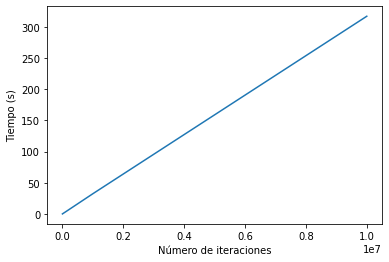

In [ ]:
plt.plot(iters, times)
plt.xlabel('Número de iteraciones')
plt.ylabel('Tiempo (s)');

Según el problema (y tenga sentido), diseña un juego de datos de entrada aleatorios

Respuesta

In [ ]:
# Lista con las categorías de los equipos. Basada en el ejemplo que aparece el las diapositivas de la asignatura.
equipos = 3*['A'] + 11*['B'] + 6*['C']

# Función que genera partidos aleatorios con todas las categorías de equipos de una jornada.
# Reordena aleatoriamente la lista de equipos y devuelve strings con pares ordenados de categorías.
def partidos_aleatorios(equipos):
    
    equipos_tmp = deepcopy(equipos)
    random.shuffle(equipos_tmp)
    
    return [''.join(sorted(a + b)) for a, b in zip(equipos_tmp[::2], equipos_tmp[1::2])]

In [ ]:
partidos_aleatorios_1 = partidos_aleatorios(equipos)
partidos_aleatorios_2 = partidos_aleatorios(equipos)

print(f'Partidos de la primera jornada por caterogía de los equipos: {partidos_aleatorios_1}')
print(f'Partidos de la segunda jornada por caterogía de los equipos: {partidos_aleatorios_2}')

Partidos de la primera jornada por caterogía de los equipos: ['BC', 'AA', 'BB', 'AC', 'BC', 'BB', 'BC', 'BC', 'BB', 'BC']
Partidos de la segunda jornada por caterogía de los equipos: ['BB', 'AC', 'BC', 'BB', 'BB', 'BC', 'AC', 'AB', 'BC', 'BC']


Aplica el algoritmo al juego de datos generado

Respuesta

In [ ]:
def pretty_print(jornada):
    
    string = ''
    
    for horario, partidos in jornada.items():
        string += f'{horario}: {", ".join(partidos)}\n'
        
    return string

In [ ]:
mejor_solucion_1, mejor_audiencia_1 = simulated_annealing(partidos_aleatorios_1, generar_insercion_aleatoria, 1000000, 100000)
print(f'La mejor audiencia obtenida para la jornada 1 es: {mejor_audiencia_1*1e6}\nLa jornada óptima será:\n{pretty_print(mejor_solucion_1)}')

La mejor audiencia obtenida para la jornada 1 es: 7057500.0
La jornada óptima será:
V20: 
S12: BC
S16: BC
S18: BB
S20: BB, BB
D12: BC
D16: BC
D18: AC
D20: AA
L20: BC



In [ ]:
mejor_solucion_2, mejor_audiencia_2 = simulated_annealing(partidos_aleatorios_2, generar_insercion_aleatoria, 1000000, 100000)
print(f'La mejor audiencia obtenida para la jornada 1 es: {mejor_audiencia_2*1e6}\nLa jornada óptima será:\n{pretty_print(mejor_solucion_2)}')

La mejor audiencia obtenida para la jornada 1 es: 6530000.0
La jornada óptima será:
V20: BC
S12: BC
S16: BB
S18: BC
S20: BB, AC
D12: BC
D16: BB
D18: AC
D20: AB
L20: 



Enumera las referencias que has utilizado(si ha sido necesario) para llevar a cabo el trabajo

Respuesta

https://es.wikipedia.org/wiki/N%C3%BAmeros_de_Stirling_de_segunda_especie

https://en.wikipedia.org/wiki/Bell_number

http://what-when-how.com/artificial-intelligence/a-comparison-of-cooling-schedules-for-simulated-annealing-artificial-intelligence/

Describe brevemente las lineas de como crees que es posible avanzar en el estudio del problema. Ten en cuenta incluso posibles variaciones del problema y/o variaciones al alza del tamaño

Respuesta

Al resolver este problema, he utilizado el algoritmo de simulated annealing para aproximar una distribución óptima de los partidos de una jornada de fútbol. La principal ventaja de este algoritmo es que nos permite explorar el espacio de soluciones de manera rápida y eficiente. Sin embargo, el algoritmo normalmente no encontrará el óptimo global, y en el contexto de optimizar la jornada de LaLiga, donde maximizar la audiencia es de vital importancia, nuestra aproximación puede no ser suficiente. Por lo tanto, es probable que una exploración del espacio de soluciones más exhaustiva sea necesaria.

Para solventar este problema y diseñar un algoritmo de simulated annealing más robusto, se pueden utilizar varias estrategias que hemos visto en clase. Por ejemplo, una limitación de la implementación actual es que hacemos uso de un único operador para generar alteraciones arbitrarias de la solución actual. Aunque se probaron varios posibles operadores y se escogió el óptimo para esta implementación, es probable que combinar varios operadores, como se explica en “Búsqueda por Entornos Variables para Planificación Logística” (y como hicimos en los ejercicios para puntuación extra de AG3), permita al algoritmo explorar el espacio de soluciones más profundamente. Esto nos permitiría encontrar soluciones más óptimas en comparación con la implementación actual con un solo operador.

Por otro lado, también es probable que usar el multiarranque pueda mejorar el rendimiento del algoritmo. En nuestra implementación, la exploración de soluciones comienza a partir de una única solución aleatoriamente generada. Es posible que repetir el proceso con varias posibles soluciones iniciales lleve a una exploración más exhaustiva y, por tanto, nos permita obtener soluciones más óptimas.

Ambas estrategias aumentarían el coste computacional del algoritmo, pero en este contexto, es probable que maximizar la audiencia tenga mayor importancia que minimizar el coste computacional.